<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/01_supervised/classification/credit_risk_classification/Bank_Loan_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Load German Credit dataset
data = fetch_openml('credit-g', as_frame=True)
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 'good' or 'bad' credit risk

import numpy as np

# Set different missingness rates per column
missing_rates = {
    'age': 0.05,       # 5% missing
    'job': 0.10,       # 10% missing
    'credit_amount': 0.02,  # 2% missing
    'purpose': 0.15    # 15% missing
}

for col, rate in missing_rates.items():
    mask = np.random.rand(len(df)) < rate
    df.loc[mask, col] = np.nan

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=31
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=44096

  warn(warning_msg)


purpose                   0.148
job                       0.102
age                       0.049
credit_amount             0.028
checking_status           0.000
duration                  0.000
credit_history            0.000
installment_commitment    0.000
savings_status            0.000
personal_status           0.000
other_parties             0.000
residence_since           0.000
employment                0.000
property_magnitude        0.000
other_payment_plans       0.000
housing                   0.000
existing_credits          0.000
num_dependents            0.000
own_telephone             0.000
foreign_worker            0.000
target                    0.000
dtype: float64


<Axes: >

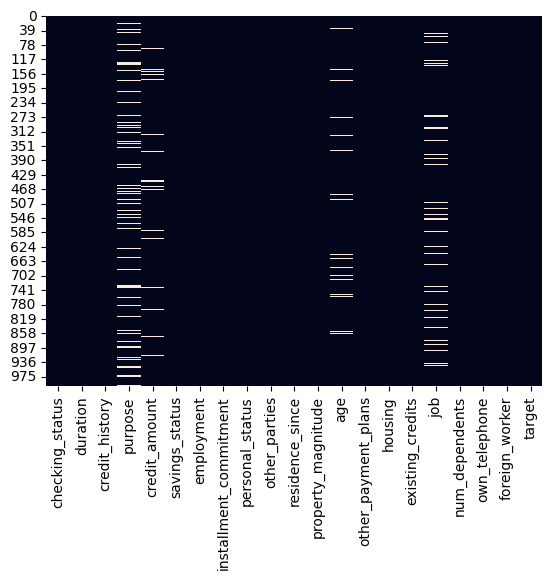

In [22]:
# Check missingness percentages
print(df.isnull().mean().sort_values(ascending=False))

# Visualize missingness pattern
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

In [30]:
# Import necessary libraries
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# 1. Split the data into features and target
X = df.drop('target', axis=1)
y = df['target'].map({'good': 1, 'bad': 0})  # Convert to binary

# 2. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.head())

    checking_status  duration                  credit_history  \
675     no checking        30  critical/other existing credit   
703        0<=X<200        30              delayed previously   
12         0<=X<200        12                   existing paid   
845        0<=X<200        21                   existing paid   
795     no checking         9                   existing paid   

                 purpose  credit_amount    savings_status employment  \
675                  NaN         4530.0              <100     4<=X<7   
703             business         2503.0        100<=X<500        >=7   
12              radio/tv         1567.0              <100     1<=X<4   
845  furniture/equipment         3976.0  no known savings     4<=X<7   
795  furniture/equipment         2301.0        100<=X<500         <1   

     installment_commitment     personal_status other_parties  \
675                       4  female div/dep/mar          none   
703                       4         male singl

In [31]:
# 3. Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# 4. Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 5. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [32]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
# Model Definitions
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

# Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')

    # Full training
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    return {
        'CV Mean F1': np.mean(cv_scores),
        'CV Std F1': np.std(cv_scores),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'Test ROC AUC': roc_auc_score(y_test, y_proba),
        'Model': pipeline
    }

# Compare Models
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(model, X_train, y_train, X_test, y_test)
    result['Name'] = name
    results.append(result)

Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 448, number of negative: 192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Evaluating Gradient Boost

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating SVM...
Evaluating KNN...


                     CV Mean F1   Test F1  Test ROC AUC
Name                                                   
Gradient Boosting      0.833365  0.852234      0.778929
Random Forest          0.827380  0.820000      0.779107
KNN                    0.807843  0.818182      0.710179
LightGBM               0.801903  0.802867      0.755952
XGBoost                0.803574  0.769231      0.727143
SVM                    0.784724  0.768627      0.775238
Logistic Regression    0.776485  0.752941      0.764524


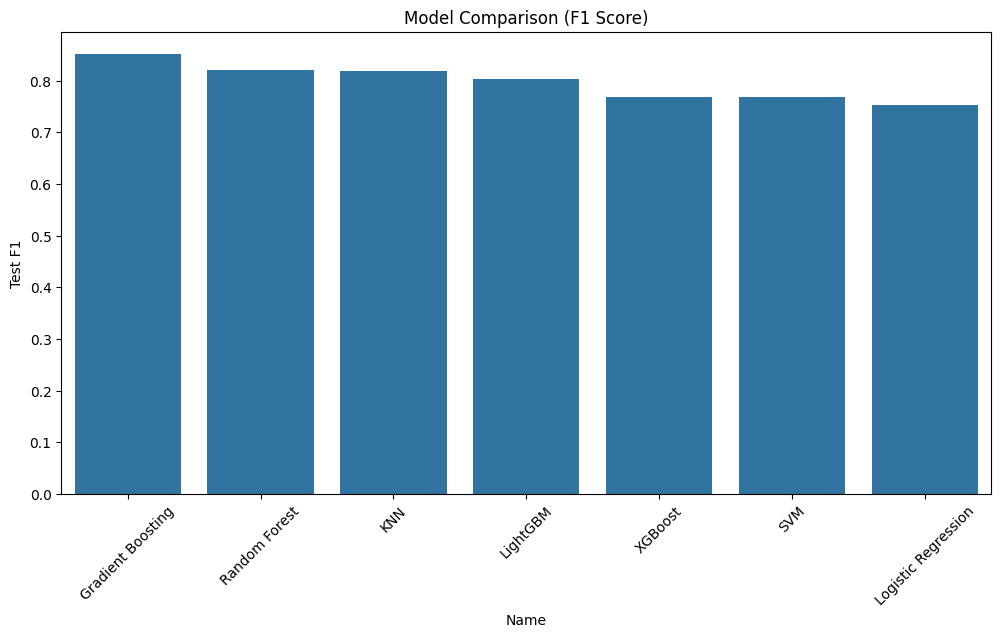

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create results dataframe
results_df = pd.DataFrame(results).set_index('Name').sort_values('Test F1', ascending=False)
print(results_df[['CV Mean F1', 'Test F1', 'Test ROC AUC']])

# Visual Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='Test F1', data=results_df)
plt.title('Model Comparison (F1 Score)')
plt.xticks(rotation=45)
plt.show()

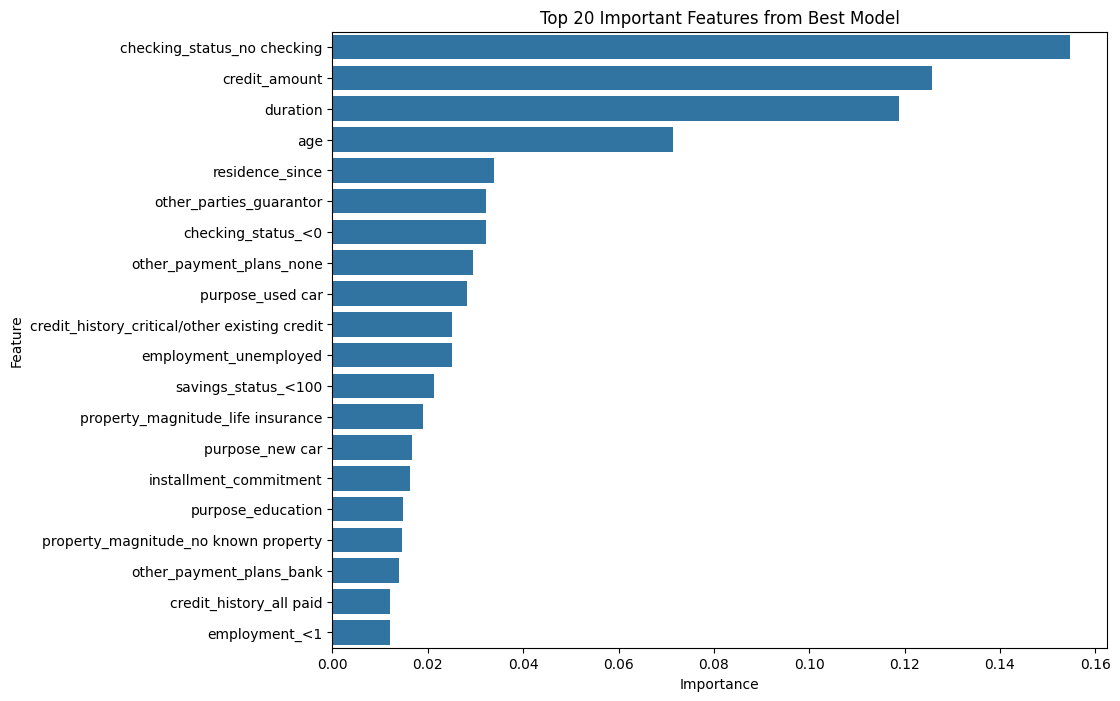

In [36]:
# Feature Importance from best model
best_model = results_df.iloc[0]['Model']
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].feature_importances_

    # Get feature names from the preprocessor
    numeric_features = list(numeric_cols)
    categorical_features = (preprocessor.named_transformers_['cat']
                          .named_steps['onehot']
                          .get_feature_names_out(categorical_cols))

    all_features = numeric_features + list(categorical_features)

    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Top 20 Important Features from Best Model')
    plt.show()

In [40]:
# Hyperparameter Tuning for Gradient Boosting
from sklearn.model_selection import GridSearchCV

if results_df.index[0] == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif results_df.index[0] in ['Random Forest', 'XGBoost', 'LightGBM']:
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif results_df.index[0] == 'Logistic Regression':
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    }

grid_search = GridSearchCV(
    best_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters for {results_df.index[0]}:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_:.4f}")

Gradient Boosting

Best parameters for Gradient Boosting:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best F1 score: 0.8433
